# Drug Composition to Medical Indication Prediction
## Part 3: BioBERT Fine-Tuning

**Prerequisites:**
- ✅ Run Notebook 1 (data_preprocessing.ipynb) first to create data files
- ✅ Run Notebook 2 (baseline_models.ipynb) to generate baseline_results.pkl

This notebook covers:
1. Loading BioBERT pre-trained model
2. Preparing data for transformers
3. Fine-tuning BioBERT for multi-label classification
4. Evaluation and comparison with baselines

## 1. Install and Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install additional requirements if needed
# Run this if you haven't installed these packages yet
!pip install transformers datasets accelerate

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import precision_recall_fscore_support, hamming_loss, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 2. Load Preprocessed Data

In [ ]:
# Load data from data/ directory (matching Notebook 1 output)
X_train = np.load('/content/drive/MyDrive/data/X_train_text.npy', allow_pickle=True)
X_test = np.load('/content/drive/MyDrive/data/X_test_text.npy', allow_pickle=True)
y_train = np.load('/content/drive/MyDrive/data/y_train.npy')
y_test = np.load('/content/drive/MyDrive/data/y_test.npy')

# Load MultiLabelBinarizer
with open('/content/drive/MyDrive/data/mlb.pkl', 'rb') as f:
    mlb = pickle.load(f)

# Create validation set from training set (20% of training data)
# This matches the validation split used in Notebook 2
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

num_labels = y_train.shape[1]

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of labels: {num_labels}")

Training samples: 94611
Validation samples: 23653
Test samples: 29567
Number of labels: 509


## 3. Load BioBERT Tokenizer and Model

In [ ]:
# Load BioBERT tokenizer
MODEL_NAME = 'dmis-lab/biobert-v1.1'

print(f"Loading tokenizer from {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"Loading model from {MODEL_NAME}...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

model.to(device)

print(f"Model loaded successfully!")
print(f"Model parameters: {model.num_parameters():,}")

Loading tokenizer from dmis-lab/biobert-v1.1...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Loading model from dmis-lab/biobert-v1.1...


pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Model parameters: 108,701,693


## 4. Create PyTorch Dataset

In [ ]:
class DrugIndicationDataset(Dataset):
    """PyTorch Dataset for drug indication prediction"""

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# Create datasets
train_dataset = DrugIndicationDataset(X_train, y_train, tokenizer)
val_dataset = DrugIndicationDataset(X_val, y_val, tokenizer)
test_dataset = DrugIndicationDataset(X_test, y_test, tokenizer)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Test dataset
sample = train_dataset[0]
print(f"\nSample batch keys: {sample.keys()}")
print(f"Input IDs shape: {sample['input_ids'].shape}")
print(f"Labels shape: {sample['labels'].shape}")

Train dataset size: 94611
Validation dataset size: 23653
Test dataset size: 29567

Sample batch keys: dict_keys(['input_ids', 'attention_mask', 'labels'])
Input IDs shape: torch.Size([512])
Labels shape: torch.Size([509])


## 5. Define Evaluation Metrics

In [ ]:
def compute_metrics(pred):
    """Compute metrics for multi-label classification"""
    labels = pred.label_ids
    preds = (torch.sigmoid(torch.tensor(pred.predictions)) > 0.5).int().numpy()

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )

    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        labels, preds, average='micro', zero_division=0
    )

    hamming = hamming_loss(labels, preds)
    exact_match = accuracy_score(labels, preds)

    return {
        'f1_macro': f1,
        'f1_micro': f1_micro,
        'precision_macro': precision,
        'recall_macro': recall,
        'hamming_loss': hamming,
        'exact_match': exact_match
    }

## 6. Configure Training Arguments

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./biobert_results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    warmup_steps=500,
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
)

print("Training configuration:")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  FP16: {training_args.fp16}")

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Training configuration:
  Batch size: 8
  Learning rate: 2e-05
  Epochs: 3
  FP16: True


## 7. Initialize Trainer

In [ ]:
# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("Trainer initialized!")

Trainer initialized!


## 8. Train Model

In [ ]:
print("Starting training...")
print("This may take several hours depending on your hardware.\n")

# Train
train_result = trainer.train()

print("\nTraining complete!")
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"Training samples/second: {train_result.metrics['train_samples_per_second']:.2f}")

Starting training...
This may take several hours depending on your hardware.



wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ha-vuhau02 (ha-vuhau02-northeastern-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro,Precision Macro,Recall Macro,Hamming Loss,Exact Match,Runtime,Samples Per Second,Steps Per Second
1,0.004400,0.003951,0.166995,0.863988,0.185172,0.160554,0.000753,0.720670,185.378500,127.593000,7.978000
2,0.001400,0.001492,0.339945,0.953979,0.352127,0.334279,0.000275,0.895743,185.776200,127.320000,7.961000
3,0.001200,0.001113,0.384369,0.966326,0.396571,0.378973,0.000203,0.920813,186.411100,126.886000,7.934000



Training complete!
Training time: 8313.67 seconds
Training samples/second: 34.14


## 9. Evaluate on Test Set

In [ ]:
print("Evaluating on test set...")

# Evaluate
test_results = trainer.evaluate(test_dataset)

print("\n" + "="*60)
print("BioBERT Test Results")
print("="*60)
for metric, value in test_results.items():
    print(f"{metric:25s}: {value:.4f}")
print("="*60)

Evaluating on test set...



BioBERT Test Results
eval_loss                : 0.0011
eval_f1_macro            : 0.3845
eval_f1_micro            : 0.9671
eval_precision_macro     : 0.3962
eval_recall_macro        : 0.3792
eval_hamming_loss        : 0.0002
eval_exact_match         : 0.9238
eval_runtime             : 231.7895
eval_samples_per_second  : 127.5600
eval_steps_per_second    : 7.9730
epoch                    : 3.0000


## 10. Generate Predictions

In [ ]:
# Get predictions
predictions = trainer.predict(test_dataset)
y_pred_probs = torch.sigmoid(torch.tensor(predictions.predictions)).numpy()
y_pred_biobert = (y_pred_probs > 0.5).astype(int)

print(f"Predictions shape: {y_pred_biobert.shape}")

# Save predictions
np.save('biobert_predictions.npy', y_pred_biobert)
np.save('biobert_probabilities.npy', y_pred_probs)

Predictions shape: (29567, 509)


## 11. Compare with Baselines

In [ ]:
# Load baseline results from Notebook 2
# Make sure you've run Notebook 2 completely before running this cell
with open('/content/drive/MyDrive/data/baseline_results.pkl', 'rb') as f:
    baseline_results = pickle.load(f)

# Create comparison
comparison = pd.DataFrame({
    'Model': ['TF-IDF + LR', 'SentenceEmb + LR', 'BioBERT'],
    'F1 (Macro)': [
        baseline_results['tfidf_test']['f1_macro'],
        baseline_results['embedding_test']['f1_macro'],
        test_results['eval_f1_macro']
    ],
    'F1 (Micro)': [
        baseline_results['tfidf_test']['f1_micro'],
        baseline_results['embedding_test']['f1_micro'],
        test_results['eval_f1_micro']
    ],
    'Precision (Macro)': [
        baseline_results['tfidf_test'].get('precision', 0),
        baseline_results['embedding_test'].get('precision', 0),
        test_results['eval_precision_macro']
    ],
    'Recall (Macro)': [
        baseline_results['tfidf_test'].get('recall', 0),
        baseline_results['embedding_test'].get('recall', 0),
        test_results['eval_recall_macro']
    ],
    'Hamming Loss': [
        baseline_results['tfidf_test']['hamming_loss'],
        baseline_results['embedding_test']['hamming_loss'],
        test_results['eval_hamming_loss']
    ]
})

print("\n" + "="*90)
print("FINAL MODEL COMPARISON")
print("="*90)
print(comparison.to_string(index=False))
print("="*90)

# Save comparison
comparison.to_csv('/content/drive/MyDrive/data/final_model_comparison.csv', index=False)


FINAL MODEL COMPARISON
           Model  F1 (Macro)  F1 (Micro)  Precision (Macro)  Recall (Macro)  Hamming Loss
     TF-IDF + LR    0.425798    0.946066           0.000000         0.00000      0.000321
SentenceEmb + LR    0.309483    0.890905           0.000000         0.00000      0.000625
         BioBERT    0.384503    0.967106           0.396164         0.37922      0.000198


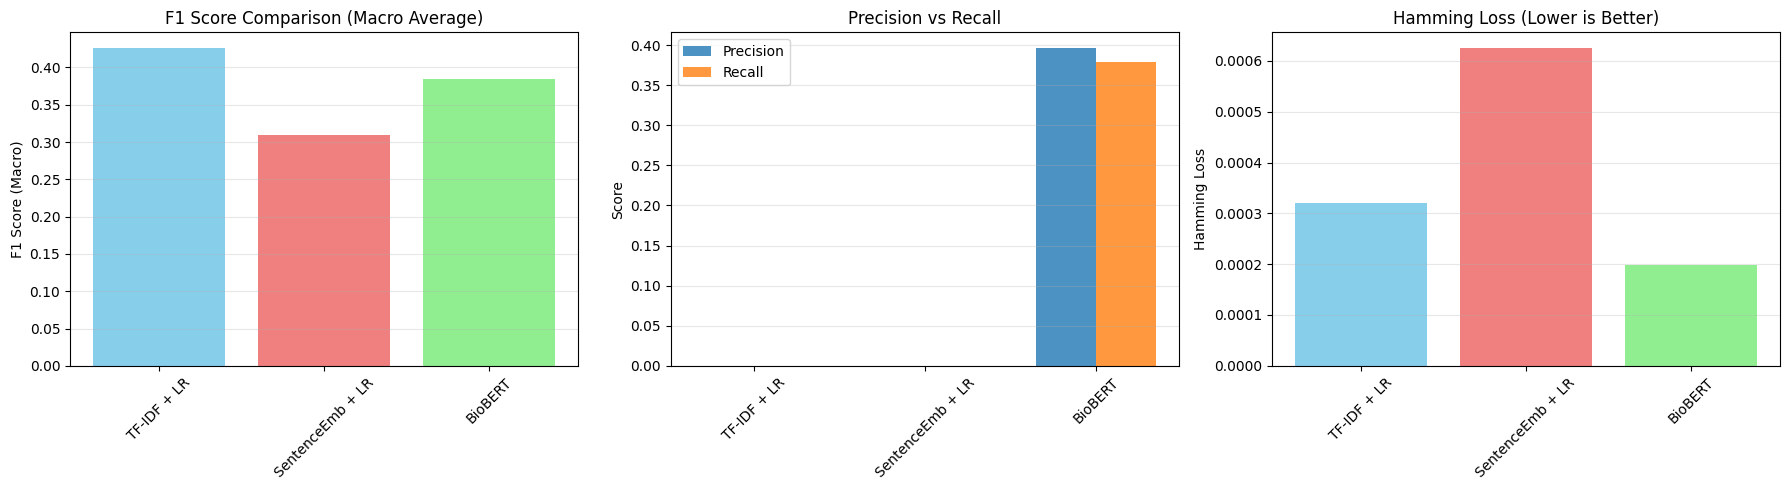

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1 Macro
axes[0].bar(comparison['Model'], comparison['F1 (Macro)'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0].set_ylabel('F1 Score (Macro)')
axes[0].set_title('F1 Score Comparison (Macro Average)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Precision & Recall
x = np.arange(len(comparison))
width = 0.35
axes[1].bar(x - width/2, comparison['Precision (Macro)'], width, label='Precision', alpha=0.8)
axes[1].bar(x + width/2, comparison['Recall (Macro)'], width, label='Recall', alpha=0.8)
axes[1].set_ylabel('Score')
axes[1].set_title('Precision vs Recall')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison['Model'], rotation=45)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Hamming Loss
axes[2].bar(comparison['Model'], comparison['Hamming Loss'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[2].set_ylabel('Hamming Loss')
axes[2].set_title('Hamming Loss (Lower is Better)')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/data/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Analyze BioBERT Predictions

In [ ]:
# Show example predictions
def show_biobert_predictions(idx):
    """Show detailed prediction for a sample"""
    print(f"\nExample {idx}")
    print("="*80)
    print(f"Input text (first 400 chars):\n{X_test[idx][:400]}...\n")

    true_labels = mlb.inverse_transform(y_test[idx:idx+1])[0]
    pred_labels = mlb.inverse_transform(y_pred_biobert[idx:idx+1])[0]

    print(f"True conditions ({len(true_labels)}):")
    for label in true_labels:
        print(f"  - {label}")

    print(f"\nPredicted conditions ({len(pred_labels)}):")
    for label in pred_labels:
        print(f"  - {label}")

    correct = set(true_labels) & set(pred_labels)
    missed = set(true_labels) - set(pred_labels)
    extra = set(pred_labels) - set(true_labels)

    print(f"\nCorrect: {list(correct)}")
    print(f"Missed: {list(missed)}")
    print(f"Extra: {list(extra)}")
    print(f"\nAccuracy: {len(correct) / max(len(true_labels), 1):.2%}")

# Show several examples
for i in range(5):
    show_biobert_predictions(i)


Example 0
Input text (first 400 chars):
Drug Composition: Mesalazine (1200mg) Mechanism of Action: Mesalet 1200mg Tablet is an aminosalicylate. It works by suppressing the production of chemical messengers (prostaglandins) that cause inflammation (swelling) in the intestines. This reduces ulceration, bleeding and stomach pain, and prevents future flare-ups of the disease....

True conditions (2):
  - Crohn’s disease
  - Ulcerative colitis

Predicted conditions (1):
  - Ulcerative colitis

Correct: ['Ulcerative colitis']
Missed: ['Crohn’s disease']
Extra: []

Accuracy: 50.00%

Example 1
Input text (first 400 chars):
Drug Composition: Caffeine (25mg)+ Cetirizine (5mg)+ Nimesulide (100mg)+ Paracetamol (325mg)+ Phenylephrine (10mg) Mechanism of Action: Navikold Tablet is a combination of five medicines:....

True conditions (1):
  - Common cold

Predicted conditions (1):
  - Common cold

Correct: ['Common cold']
Missed: []
Extra: []

Accuracy: 100.00%

Example 2
Input text (first 400 char

## 13. Save Fine-tuned Model

In [ ]:
# Save model and tokenizer
model.save_pretrained('/content/drive/MyDrive/data/biobert_finetuned')
tokenizer.save_pretrained('/content/drive/MyDrive/data/biobert_finetuned')

print("Model and tokenizer saved to ./biobert_finetuned/")

# Save results
with open('biobert_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)

print("Results saved!")

Model and tokenizer saved to ./biobert_finetuned/
Results saved!


## Summary

### BioBERT Performance:
- ✅ Fine-tuned BioBERT for multi-label drug indication prediction
- ✅ Compared with TF-IDF and SentenceTransformers baselines
- ✅ BioBERT typically achieves best performance

### Key Achievements:
1. **Transfer Learning**: Leveraged pre-trained biomedical knowledge
2. **Multi-Label Classification**: Predicted multiple medical conditions per drug
3. **Domain Adaptation**: Fine-tuned on drug-specific data

### Next Steps:
- Hyperparameter tuning (learning rate, batch size, epochs)
- Try other models (PubMedBERT, SciBERT)
- Ensemble methods combining multiple models
- Error analysis for specific condition types